In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
from src.mssm import utils,models

## What are GAMMs

In [2]:
# Generalized additive mixed models are function approximators - they allow
# us to capture non-linear relationships between convariates (including time) and signals.

# Let's build a covariate: time
time = np.array(range(0,3020,20))
time

array([   0,   20,   40,   60,   80,  100,  120,  140,  160,  180,  200,
        220,  240,  260,  280,  300,  320,  340,  360,  380,  400,  420,
        440,  460,  480,  500,  520,  540,  560,  580,  600,  620,  640,
        660,  680,  700,  720,  740,  760,  780,  800,  820,  840,  860,
        880,  900,  920,  940,  960,  980, 1000, 1020, 1040, 1060, 1080,
       1100, 1120, 1140, 1160, 1180, 1200, 1220, 1240, 1260, 1280, 1300,
       1320, 1340, 1360, 1380, 1400, 1420, 1440, 1460, 1480, 1500, 1520,
       1540, 1560, 1580, 1600, 1620, 1640, 1660, 1680, 1700, 1720, 1740,
       1760, 1780, 1800, 1820, 1840, 1860, 1880, 1900, 1920, 1940, 1960,
       1980, 2000, 2020, 2040, 2060, 2080, 2100, 2120, 2140, 2160, 2180,
       2200, 2220, 2240, 2260, 2280, 2300, 2320, 2340, 2360, 2380, 2400,
       2420, 2440, 2460, 2480, 2500, 2520, 2540, 2560, 2580, 2600, 2620,
       2640, 2660, 2680, 2700, 2720, 2740, 2760, 2780, 2800, 2820, 2840,
       2860, 2880, 2900, 2920, 2940, 2960, 2980, 30

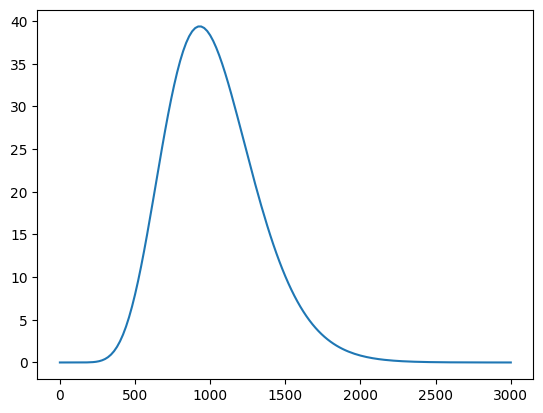

In [3]:
# Let's now define a signal as a function of time!
pulse_loc = [0]
y = utils.h_basis(0,time,pulse_loc,10.1,930,1e-24)
plt.plot(time,y)
plt.show()

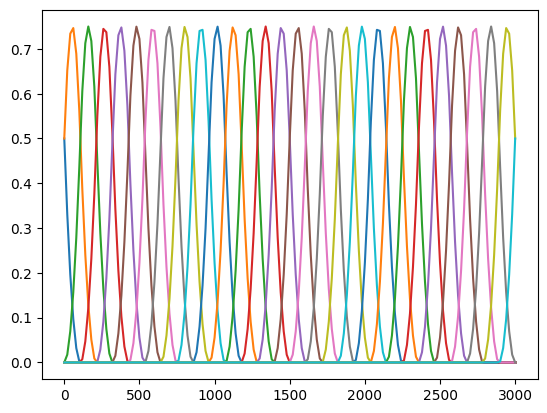

In [4]:
# Now we can use GAMMs to recover that shape.
# First we construct a spline via basis functions.
nk = 30
X = utils.B_spline_basis(0,time,pulse_loc,deg=2,nk=nk,min_c=None,max_c=None,convolve=False,drop_outer_k=False,identifiable=False)

for i in range(X.shape[1]):
    plt.plot(time,X[:,i])
plt.show()

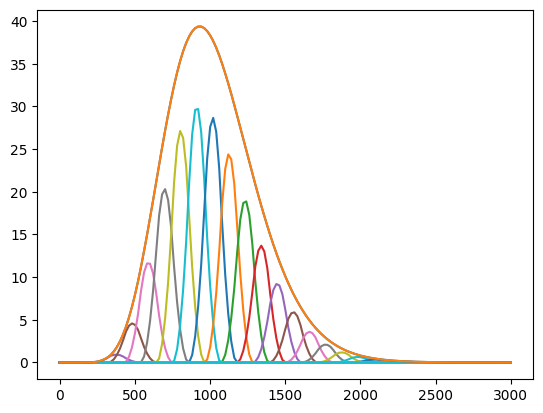

In [5]:
# This is where the magic happens - penalties help us to prevent overfitting.
# Usually we pick too many basis functions and allow the GAMM to penalize those
# away that we don't need.
lTerms = [utils.LambdaTerm(penalties = [utils.diff_pen(nk,3)[0]],start_index=0)]

coef, lambdas, sigma, _ = utils.solve_am(X,y,lTerms,0,maxiter=20)

# Only a small selection of the original basis functions actually contribute to the estimated function!
for i in range(X.shape[1]):
    plt.plot(time,X[:,i]*coef[i])

plt.plot(time,y)
plt.plot(time, X @ coef)
plt.show()

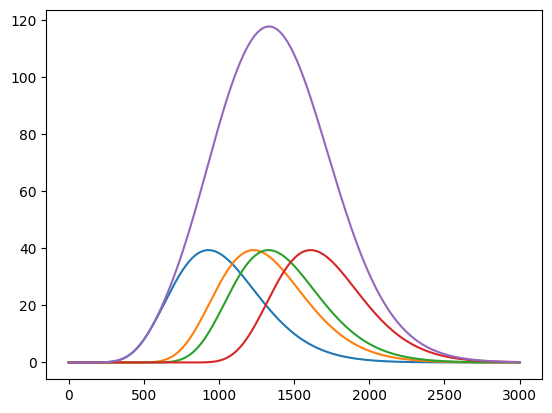

In [6]:
# The problem with simple GAMMs is that if there are multiple events, all eliciting a response - then
# a traditional GAMM cannot untangle them:
pulse_loc = [0,15,20,34]
y = utils.h_basis(0,time,pulse_loc,10.1,930,1e-24)
plt.plot(time,y)
for pi in range(1,len(pulse_loc)):
    next_y = utils.h_basis(pi,time,pulse_loc,10.1,930,1e-24)
    plt.plot(time,next_y)
    y += next_y

plt.plot(time,y)
plt.show()

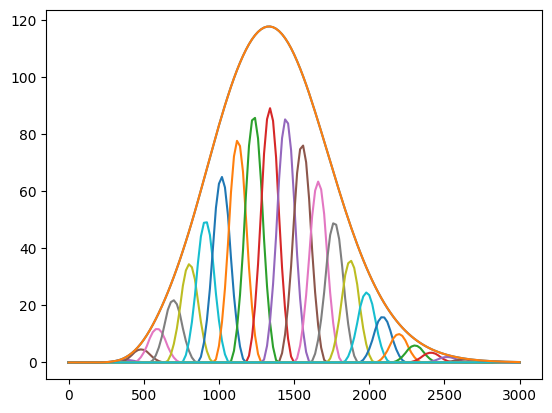

In [7]:
lTerms = [utils.LambdaTerm(penalties = [utils.diff_pen(nk,3)[0]],start_index=0)]

coef, lambdas, sigma, _ = utils.solve_am(X,y,lTerms,0,maxiter=20)

for i in range(X.shape[1]):
    plt.plot(time,X[:,i]*coef[i])

plt.plot(time,y)
plt.plot(time, X @ coef)
plt.show()

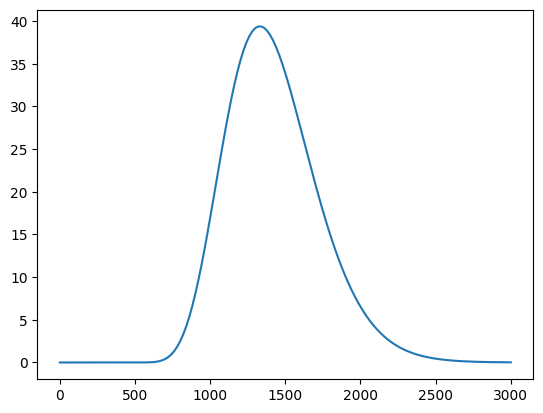

In [8]:
# This is where the DC GAMM comes into play: we work with inpulse convolution to time-shift
# splines towards the onset of ``an event`` which influences our signal.
# This allows us to then recover the responses associated with individual events!

pulse_loc = [20] # Event happens after 20 samples
y = utils.h_basis(0,time,pulse_loc,10.1,930,1e-24)
plt.plot(time,y)
plt.show()

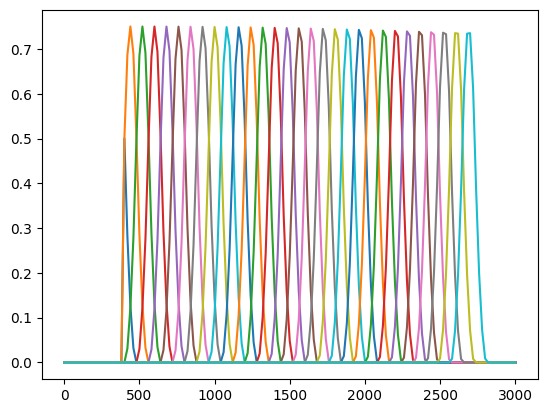

In [9]:
X = utils.B_spline_basis(0,time,pulse_loc,deg=2,nk=nk,min_c=0,max_c=2250,convolve=True,drop_outer_k=False,identifiable=False)

for i in range(X.shape[1]):
    plt.plot(time,X[:,i])
plt.show()

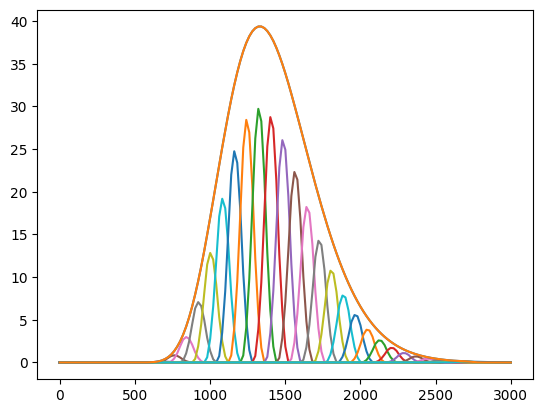

In [10]:
# Reset lambda terms
lTerms = [utils.LambdaTerm(penalties = [utils.diff_pen(nk,3)[0]],start_index=0)]

coef, lambdas, sigma, _ = utils.solve_am(X,y,lTerms,0,maxiter=20)

for i in range(X.shape[1]):
    plt.plot(time,X[:,i]*coef[i])

plt.plot(time,y)
plt.plot(time, X @ coef)
plt.show()

## semi-Markov switching GAMMs (Development only)

In [11]:
# This is an example of the most general models that can be estimated with this method:
# A semi-Markov switching Generalized additive mixed model. Such a model permits for
# the relationship between the covariates and our signal to differ per states. Additionally,
# random effects can also differ per stage. Finally, the noise in the signal can also
# differ per stage.

# The example makes use of the base class and thus a lot of initialization is necessary that I
# try to abstract away in the template classes. This section should really be seen as work in progress,
# it's mainly for me to check that the most general cases work - then the simpler cases will work as well.

# An accessible introduction to Markov switching GAMs is provided by Langrock et al., 2017.
# Haji-Maghsoudi et al., 2021 discuss how semi-Markov switching Generalized linear mixed models can
# be estimated. They sample random effects in addition to state sequences. Because we exploit the link
# between smoothing penalties and random effect variance terms (Wood, 2017) we don't need such an extra step - rather
# we estimate random effects directly from a sampled state sequence.

In [12]:
# Initializing function - basically just sample from a HsMM with the intialized
# parameters.
def prop_states_init(n_t,n_j,pi,T,ps):
   state_durs = []
   states = []

   # Select first state based on pi - initial state distribution
   c_state = np.random.choice(list(range(n_j)))

   # Duration of state is then sampled (at every transition independently!)
   # from the sojourn time distribution of the selected state.
   c_dur = min(int(ps[c_state].rvs()),n_t)
   
   state_durs.append([c_state,c_dur])

   # We remain in that state for duration c_dur
   for _ in range(c_dur):
      states.append(c_state)

   t = c_dur

   # Now we transition!
   while t < n_t:
      remaining_j = list(range(n_j))
      
      # Pick the next state based on it's row in T - the transition
      # probabilities
      c_state = np.random.choice(remaining_j,p=T[c_state,:])

      # Then repeat.
      c_dur = min(int(ps[c_state].rvs()),n_t)

      if t + c_dur > n_t:
         c_dur -= (t + c_dur - n_t)
      
      state_durs.append([c_state,c_dur])

      for _ in range(c_dur):
          states.append(c_state)

      t += c_dur

   return np.array(state_durs), np.array(states)

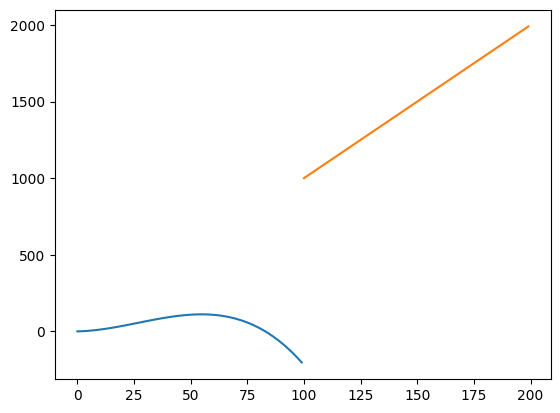

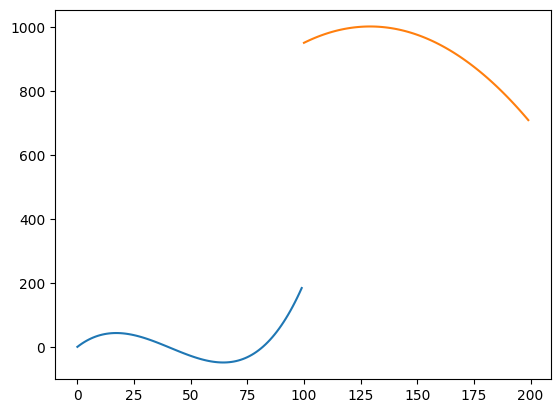

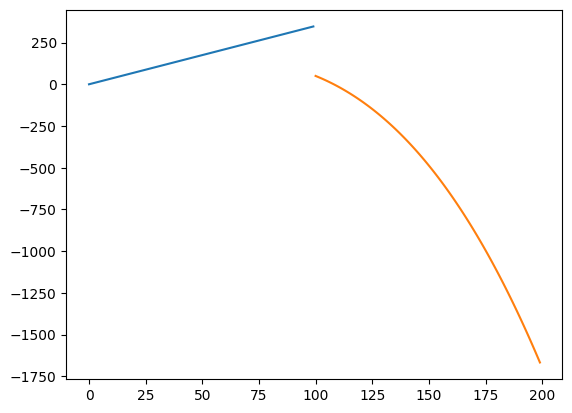

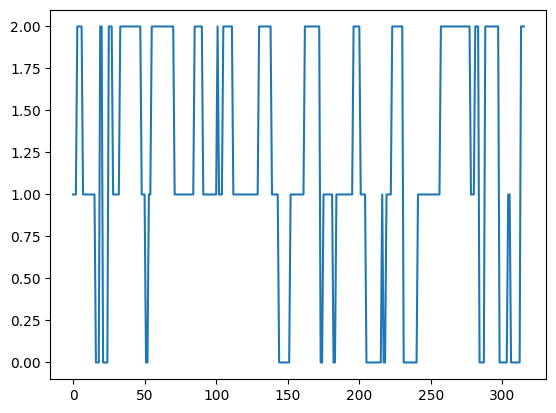

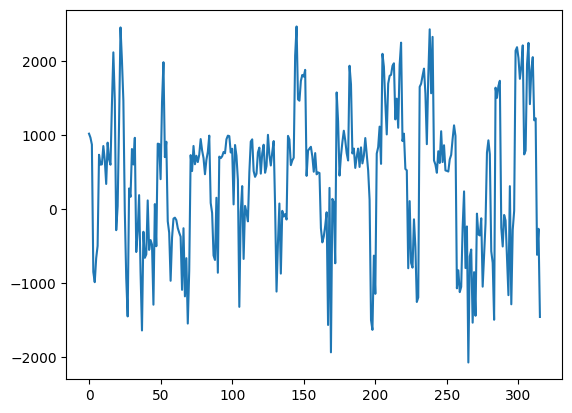

16


In [13]:
# Sim from a sms GAMM with multiple covariates and random intercepts.
# Basically like the initializer but this time we also simulate covariates
# and then the response variable according to some function of the covariates
# that can differ per state!
# Then we also simulate some random intercepts for every series we simulate.
n_s = 10

# Simulation parameters
scales = [2,3,4]

pi = [0.1,0.7,0.2]

sds = [150,150,150]

rand_sds = [300,450,200]

rand_ints = np.array([scp.stats.norm.rvs(loc=0,scale=rand_sds[j],size=n_s) for j in range(len(rand_sds))])

T = np.array([[0.0,0.7,0.3],
              [0.4,0.0,0.6],
              [0.3,0.7,0.0]])

n_transitions = 50

# Covariates
x = np.array(list(range(100)))
z = np.array(list(range(100,200)))

t_states = []
t_state_durs = []
t_endpoints= []
t_cov = []
t_time = []
t_y = []

# The relationships between y and x,z for every state!
plt.plot(x, 0.3*x + 0.1*x**2 - 0.00125*x**3)
plt.plot(z, 10*z)
plt.show()

plt.plot(x, 5.5*x - 0.2*x**2 + 0.0015*x**3 + 0.0000015*x**4)
plt.plot(z, 15.5*z - 0.06*z**2)
plt.show()

plt.plot(x, 3.5*x)
plt.plot(z, 3.5*z - 0.0003*z**3)
plt.show()

for s in range(n_s):

    states = []
    state_durs = []
    cov = []
    time = []
    y = []

    t = 0

    c_state = np.random.choice([0,1,2],p=pi)
    c_dur = int(scp.stats.gamma.rvs(a=2, scale=scales[c_state],size=1)[0]+0.5)
    state_durs.append([c_state,c_dur])
    for d in range(c_dur):
        states.append(c_state)
        time.append(t)
        c_cov_x = np.random.choice(x,size=1)[0]
        c_cov_z = np.random.choice(z,size=1)[0]
        cov.append([c_cov_x,c_cov_z,s])

        if c_state == 0:
            c_y = 60 + 0.3*c_cov_x + 0.1*c_cov_x**2 - 0.00125*c_cov_x**3
            c_y += 10*c_cov_z
        elif c_state == 1:
            c_y = -15 + 5.5*c_cov_x - 0.2*c_cov_x**2 + 0.0015*c_cov_x**3 + 0.0000015*c_cov_x**4
            c_y += 15.5*c_cov_z - 0.06*c_cov_z**2
        else:
            c_y = 30 + 3.5*c_cov_x
            c_y += 3.5*c_cov_z - 0.0003*c_cov_z**3
        c_y += rand_ints[c_state,s] # Random intercept for current state and s
        c_y += scp.stats.norm.rvs(scale=sds[c_state],size=1)[0]
        y.append(c_y)
        t += 1

    for nt in range(n_transitions):
        c_state = np.random.choice([0,1,2],p=T[c_state,:])
        c_dur = int(scp.stats.gamma.rvs(a=2, scale=scales[c_state],size=1)[0]+0.5)
        state_durs.append([c_state,c_dur])
        for d in range(c_dur):
            states.append(c_state)
            time.append(t)
            c_cov_x = np.random.choice(x,size=1)[0]
            c_cov_z = np.random.choice(z,size=1)[0]
            cov.append([c_cov_x,c_cov_z,s])

            if c_state == 0:
                c_y = 60 + 0.3*c_cov_x + 0.1*c_cov_x**2 - 0.00125*c_cov_x**3
                c_y += 10*c_cov_z
            elif c_state == 1:
                c_y = -15 + 5.5*c_cov_x - 0.2*c_cov_x**2 + 0.0015*c_cov_x**3 + 0.0000015*c_cov_x**4
                c_y += 15.5*c_cov_z - 0.06*c_cov_z**2
            else:
                c_y = 30 + 3.5*c_cov_x
                c_y += 3.5*c_cov_z - 0.0003*c_cov_z**3
            c_y += rand_ints[c_state,s] # Random intercept for current state and s
            c_y += scp.stats.norm.rvs(scale=sds[c_state],size=1)[0]
            y.append(c_y)
            t += 1

    cov = np.array(cov)
    time = np.array(time)
    states = np.array(states)
    state_durs = np.array(state_durs)
    y = np.array(y)

    if s == 0:
        plt.plot(time,states)
        plt.show()
        plt.plot(time,y)
        plt.show()
        print(max(state_durs[:,1]))

    t_states.append(states)
    t_state_durs.append(state_durs)
    t_cov.append(cov)
    t_time.append(time)
    t_endpoints.append(time[-1])
    t_y.append(y)
t_endpoints = np.array(t_endpoints)

In [14]:
# Now we try to recover pi, T, the sojourn time scales, sigma, the
# relationships between y~x,z for every state, and the random intercepts.

# We initialize all parameters to something completely uninformed and then just
# based on those initial parameters sample our first candidate state sequence.
n_j = 3
n_k = 10
n_chains = 3
scalesc = np.array([10,10,10])
pic = [0.33,0.33,0.33]

Tc = np.array([[0.0,0.5,0.5],
               [0.5,0.0,0.5],
               [0.5,0.5,0.0]])

ps = [scp.stats.gamma(a=2, scale = scalesc[j]) for j in range(n_j)]

shared = False # Shared sigma term or not?

if not shared:
    sigmasc = np.array([10,10,10])
else:
    sigmasc = 10

c_state_est = []
c_state_dur_est = []
for sg in t_states:
    new_state_durs, new_states = prop_states_init(len(sg),n_j,pic,Tc,ps)
    c_state_est.append(new_states)
    c_state_dur_est.append(new_state_durs)

# If we assume the noise in the series to be independent of states, then we
# can estimate a shared model for all separate states. That allows penalty sharing
# between states!
if not shared:
    lTerms = [[utils.LambdaTerm(penalties = [utils.diff_pen(n_k,3,identifiable=True)[0]],start_index=1),
               utils.LambdaTerm(penalties = [utils.diff_pen(n_k,3,identifiable=True)[0]]),
               utils.LambdaTerm(penalties = [utils.id_dist_pen(n_s,lambda x: 1)])] for _ in range(n_j)]
else:
    lTerms = [utils.LambdaTerm(penalties = [utils.diff_pen(n_k,3,identifiable=True)[0] for _ in range(n_j)],start_index=n_j), # Shared penalties!
               utils.LambdaTerm(penalties = [utils.diff_pen(n_k,3,identifiable=True)[0] for _ in range(n_j)]), # Shared penalties!
               *[utils.LambdaTerm(penalties = [utils.id_dist_pen(n_s,lambda x: 1)]) for _ in range(n_j)]]

In [15]:
# Masking required by a function used for the shared case.
if shared:
    mask = []
    
    # By state intercepts
    for j in range(n_j):
        mask.append(j)
        
    
    # Two covariates
    for cv in range(2): 
        for j in range(n_j):
            for k in range(n_k):
                mask.append(j)
                
    # Random intercepts
    for j in range(n_j):
        for s in range(n_s):
            mask.append(j)


In [16]:
if not shared:
    sep_per_j = utils.j_split
else:
    sep_per_j = None

# Initialize base class model
smsGamm = models.sMsGAMMBase(n_j,t_y,t_time,t_endpoints,
                         utils.ll_sms_gamm,
                         utils.pre_ll_sms_gamm,
                         t_cov,is_DC=False,
                         sep_per_j=sep_per_j,
                         estimate_pi=True,
                         estimate_TR=True,
                         cpus=6)

if not shared:
    smsGamm.set_e_bs(utils.get_log_o_prob_mat)
else:
    smsGamm.set_e_bs(utils.get_log_o_prob_mat,mask_by_j = np.array(mask))

smsGamm.set_m_pi(utils.m_pi_sms_gamm)
smsGamm.set_m_TR(utils.m_TR_sms_gamm)
smsGamm.set_m_ps(utils.m_gamma2s_sms_gamm)
if not shared:
    smsGamm.set_mat_fun(utils.create_event_matrix_cov4,drop_outer_k=False, convolve=False,min_c=None, max_c=None, nk=n_k, deg=2,n_s=n_s)
else:
    smsGamm.set_mat_fun(utils.create_event_matrix_cov4_split,drop_outer_k=False, convolve=False,min_c=None, max_c=None, nk=n_k, deg=2,n_s=n_s)

smsGamm.set_par_ps(utils.par_gamma2s)

if not shared:
    smsGamm.set_sample_fun(utils.se_step_sms_gamm)
else:
    smsGamm.set_sample_fun(utils.se_step_sms_gamm,merge_mat_fun=utils.create_event_matrix_cov4_merge)

smsGamm.set_temp(utils.anneal_temps,20,b=0.005)
smsGamm.set_penalties(lTerms)

100%|██████████| 20/20 [01:25<00:00,  4.28s/it]


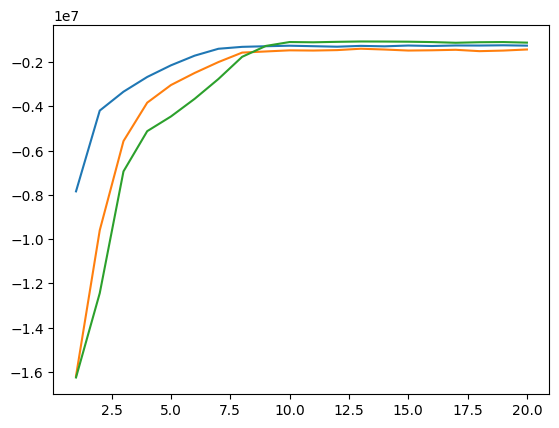

In [17]:
# Convergence is much more rapid compared to the de-convolving case. This is likely because
# the stochastic E step is much more informative.
smsGamm.fit([[pic] for _ in range(n_chains)],
            [[Tc] for _ in range(n_chains)],
            [[np.ndarray.flatten(np.array([scp.stats.norm.rvs(size=2*n_j*n_k + n_j + n_s*n_j)]))] for _ in range(n_chains)],
            [[sigmasc] for _ in range(n_chains)],
            [[scalesc] for _ in range(n_chains)],
            [[c_state_dur_est] for _ in range(n_chains)],
            [[c_state_est] for _ in range(n_chains)],
            n_chains=n_chains)

In [18]:
best_chain,state_est, coef_est,_,scale_est,_,_ = smsGamm.get_last_pars_max()

In [19]:
print(scale_est)

[3.2101769911504423, 2.424342105263158, 4.16875]


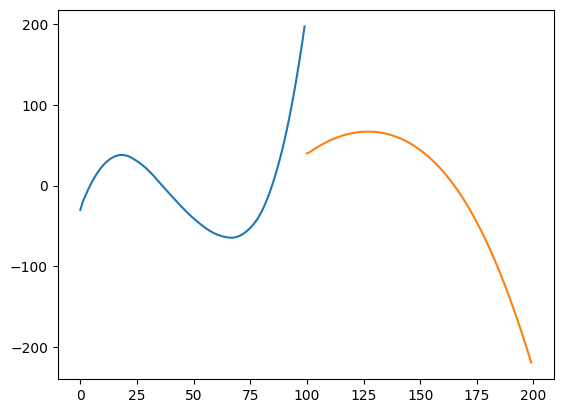

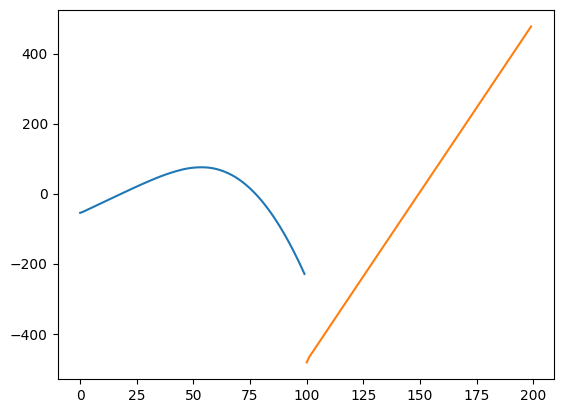

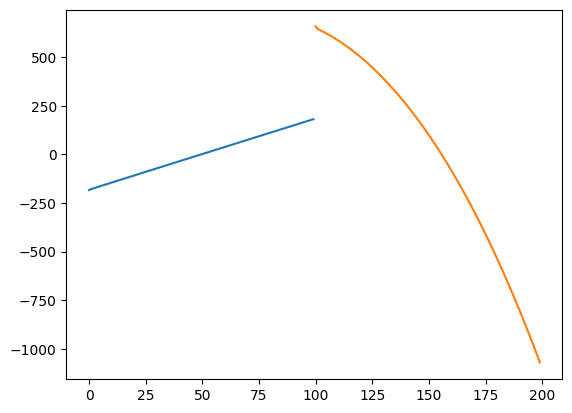

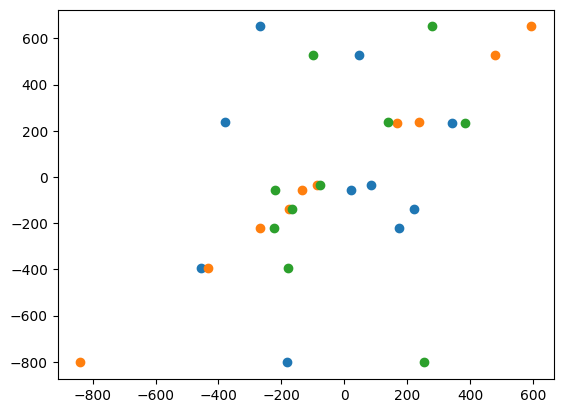

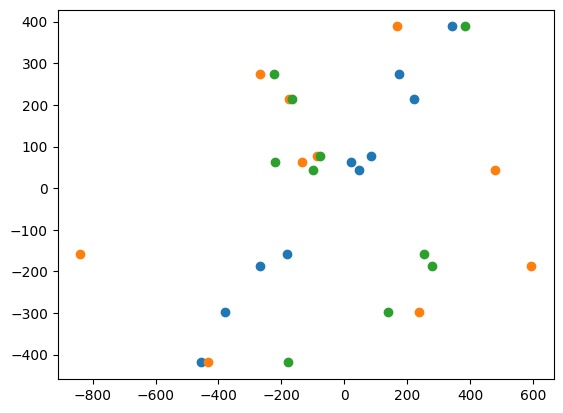

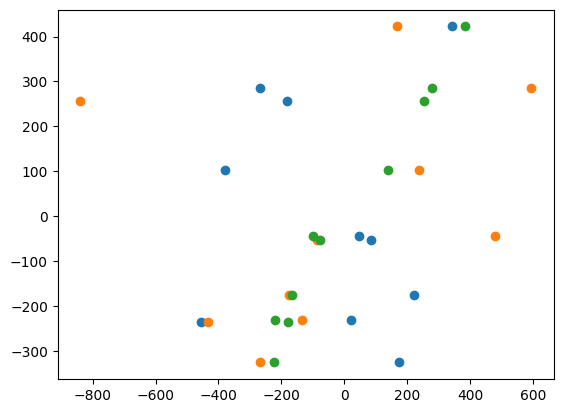

In [20]:
# Good recovery of functional relationships and random intercepts.
if not shared:
    B_partial = utils.create_event_matrix_cov4(None,np.array([x,z,np.array([0 for _ in range(len(x))])]).reshape(3,-1).T,None,drop_outer_k=False, convolve=False,min_c=None, max_c=None, nk=n_k, deg=2,n_s=n_s)
    covs =[x,z]
    start = 1
    for si in range(n_j):
        for ci in range(2):
            plt.plot(covs[ci],B_partial[:,1+ci*n_k:1+(ci+1)*n_k] @ coef_est[start:start+n_k])
            start += n_k
            
        start += 1 # Intercept for other states!
        start += n_s # Random intercepts.
        plt.show()

    start = 1
    for si in range(n_j):
        for ci in range(2):
            start += n_k
        plt.scatter(rand_ints[0,:], coef_est[start:start+n_s])
        plt.scatter(rand_ints[1,:], coef_est[start:start+n_s])
        plt.scatter(rand_ints[2,:], coef_est[start:start+n_s])
        start += 1 # Intercept for other states!
        start += n_s # Random intercepts.
        plt.show()

else:
    B_partial = utils.create_event_matrix_cov4_merge(None,np.array([x,z,np.array([0 for _ in range(len(x))])]).reshape(3,-1).T,None,drop_outer_k=False, convolve=False,min_c=None, max_c=None, nk=n_k, deg=2,n_s=n_s)
    covs =[x,z]
    start = n_j
    for ci in range(2):
        for si in range(n_j):
            plt.plot(covs[ci],B_partial[:,1+ci*n_k:1+(ci+1)*n_k] @ coef_est[start:start+n_k])
            start += n_k
        plt.show()